# Health Insurance Cross Selling Prediction

The goal is to predict whether health insurance owners' from past year would also be interested in purchasing vehicle insurance coverage provided by the Company.

In the first step, the cross-selling prediction activity, have been used calibrated classifiers. Logistic Regression has been employed as a benchmark model and it has been compared with other machine learning models such as Naïve Bayes and Hist Gradient Boosting Machine. The ensemble model shows the best performance.

In the second step, has been profiled customers interested in the purchasing coverage using K-means clustering method on numerical features and then applying the split to the all data set. In this way has been possible to understand relationships between numerical features as Annaul Premium and Age with categorical features as Vehicle Age, Gender and Vehicle Damage.

# Prepare Workspace

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import scipy
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import pickle
import time
import shap


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
print(np.__version__)

1.23.3


In [4]:
print(pd.__version__)

1.1.3


In [5]:
print(matplotlib.__version__)

3.6.3


In [6]:
print(sns.__version__)

0.12.2


In [7]:
print(scipy.__version__)

1.9.3


In [8]:
print(sklearn.__version__)

1.0.2


In [9]:
print(shap.__version__)

0.38.1


In [10]:
df = pd.read_csv('train.csv')

# Data Set Overview

The data set is composed by 12 variables and 381.109 rows

In [11]:
print(df.shape)

(381109, 12)


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None


In [13]:
print(df.columns)

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [14]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Data Cleaning

In [15]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(381109, 12)


In [16]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(381109, 12)


In [17]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

In [18]:
# Formatting features
df['Driving_License'] = df['Driving_License'].astype('object')
df['Region_Code'] = df['Region_Code'].astype('object')
df['Previously_Insured'] = df['Previously_Insured'].astype('object')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('object')
df['Response'] = df['Response'].astype('object')

# Summary Statistics

In [19]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,381109,2,Male,206089
Driving_License,381109,2,1,380297
Region_Code,381109,53,28,106415
Previously_Insured,381109,2,0,206481
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,Yes,192413
Policy_Sales_Channel,381109,155,152,134784
Response,381109,2,0,334399


In [20]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype!='object']
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0


In [21]:
# Split data set between target variable and features
X_full = df.copy()
y = X_full.Response
X_full.drop(['Response'], axis=1, inplace=True)

# Target Variable Analysis

The outcome is a binary variable with 1 value for policyholders interested in purchasing the vehicle insurance, 
instead with 0 value for policyholders not interested in it.

Target variable shows imbalanced classes, where only 12% of policyholders would buy the vehicle coverage.

In [22]:
# Summarize the class distribution 
count = pd.crosstab(index = y, columns="count")
percentage = pd.crosstab(index = y, columns="frequency")/pd.crosstab(index = y, columns="frequency").sum()
pd.concat([count, percentage], axis=1)

col_0,count,frequency
Response,,
0,334399,0.877437
1,46710,0.122563


In [23]:
def catcharts(data, col1, col2):
    plt.rcParams['figure.figsize']=(15,5)
    
    plt.subplot(1,2,1)
    data.groupby(col1).count()[col2].plot(kind='pie',autopct='%.0f%%').set_title("Pie {} Variable Distribution".format(col1))
    
    plt.subplot(1,2,2)
    sns.countplot(x=data[col1], data=data).set_title("Barplot {} Variable Distribution".format(col1))
    
    plt.show()

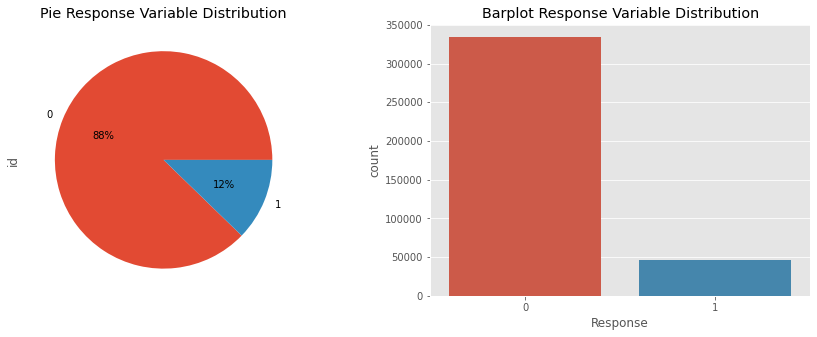

In [24]:
col1 = 'Response'
col2 = 'id'
catcharts(df, col1, col2)

# Numerical Features Analysis

After data cleaning activity, there are three numerical variables in the data set: age, annual premium and vintage aka number of days policyholder is in the Company portfolio.

Age doesn't follow a Gaussian distribution and portfolio is representd by young people.

Vintage follows a Uniform distribution with a more or less average of 150 days.

Annual premium is highly skewed with a more or less average of Rs. 30500 premium paid in the year.

### Analysis for numerical features (univariate analysis, bivariate analysis)

In [25]:
# Select numerical columns
X_full.drop(['id'], axis=1, inplace=True)
numerical_cols = [var for var in X_full.columns if X_full[var].dtype in ['float64','int64']]

In [26]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Age', 'Annual_Premium', 'Vintage'], dtype='object')

### Visualization

In [27]:
def numcharts(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.show()

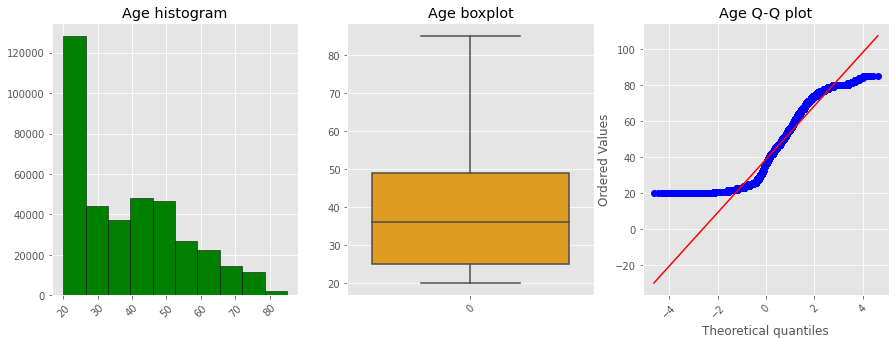

In [28]:
numcharts(num, var='Age')

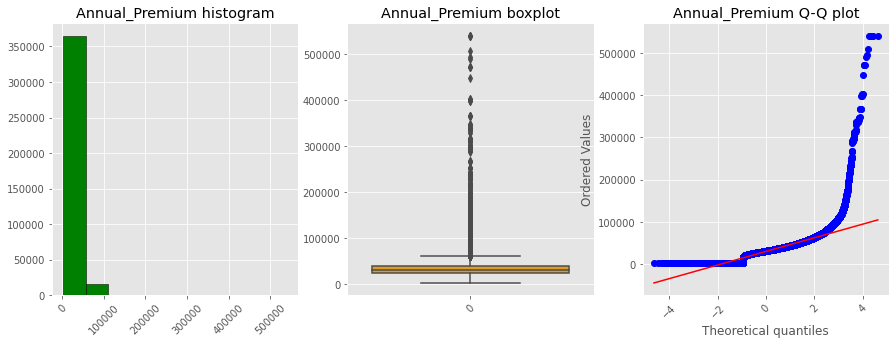

In [29]:
numcharts(num, var='Annual_Premium')

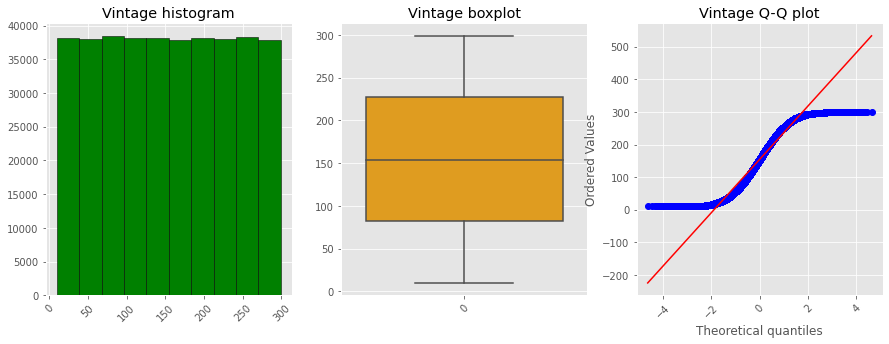

In [30]:
numcharts(num, var='Vintage')

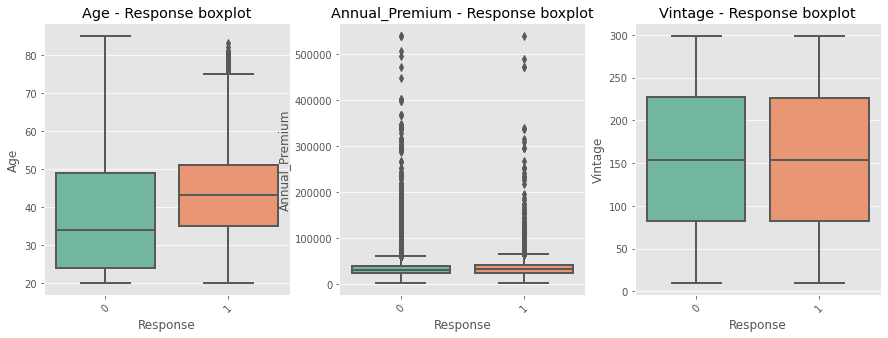

In [31]:
# new subset for a bivariate analysis
num2 = pd.concat([y,num], axis=1)
plt.rcParams['figure.figsize']=(15,5)
plt.subplot(1,3,1)
sns.boxplot(y='Age', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Age'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,2)
sns.boxplot(y='Annual_Premium', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Annual_Premium'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,3)
sns.boxplot(y='Vintage', x=y, data=num2, linewidth=2, palette="Set2")
plt.title('{} - Response boxplot'.format('Vintage'))
plt.xticks(rotation=45)
    
plt.show()

### Statistical Analysis

In [32]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
for col in num:
    print(col,
        '\nMean :', np.mean(num[col]),  
        '\nVariance :', np.var(num[col]),
        '\nStandard Deviation :', np.var(num[col]**0.5), 
        '\nSkewness :', stats.skew(num[col]), 
        '\nKurtosis :', stats.kurtosis(num[col]))

Age 
Mean : 38.822583565331705 
Variance : 240.609445034806 
Standard Deviation : 1.4713433772287088 
Skewness : 0.6725363506891485 
Kurtosis : -0.5656633888102887
Annual_Premium 
Mean : 30564.389581458323 
Variance : 296291929.5669131 
Standard Deviation : 3357.409308330456 
Skewness : 1.7660802637778974 
Kurtosis : 34.00410682771704
Vintage 
Mean : 154.34739667654136 
Variance : 7000.86868079634 
Standard Deviation : 14.1050642955642 
Skewness : 0.003029504966164472 
Kurtosis : -1.2006880332858327


# Categorical Features Analysis

With data cleaning have been dropped two variables: 'Policy_Sales_Channel' and 'Region_Code' because they are not useful in the modelling activity, given that data are allocated in many classes. In the first one variable, more or less 70% of data are covered by 3 channels, in the second variable one more or less 40% of data are allocated in 2 regions and the rest in other many other not relevant region codes.

Looking at the other variables, gender variable shows a prevalence of men policyholders: 54% male vs 46% female.

Almost all of policyholders have a driving license, and they own young vehicle: 53% of vehicles are in a range of 1-2 years.

Most of policyholders did not previously insured with the Company: 54% did not insured with Company vs 46% previusly insured.

In the last features vehicles with damage and without damage are equally distribuited in the portfolio.

### Analysis for categorical features (univariate analysis, bivariate analysis)

In [33]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

Gender :  2  labels
Driving_License :  2  labels
Region_Code :  53  labels
Previously_Insured :  2  labels
Vehicle_Age :  3  labels
Vehicle_Damage :  2  labels
Policy_Sales_Channel :  155  labels


In [34]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [var for var in X_full.columns if
                    X_full[var].nunique() <= 15 and 
                    X_full[var].dtype == "object"]

In [35]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns

Index(['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage'],
      dtype='object')

### Visualization

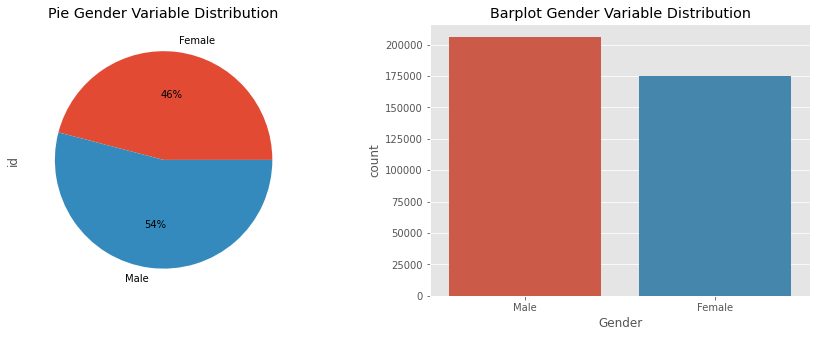

In [36]:
catcharts(df, col1='Gender', col2='id')

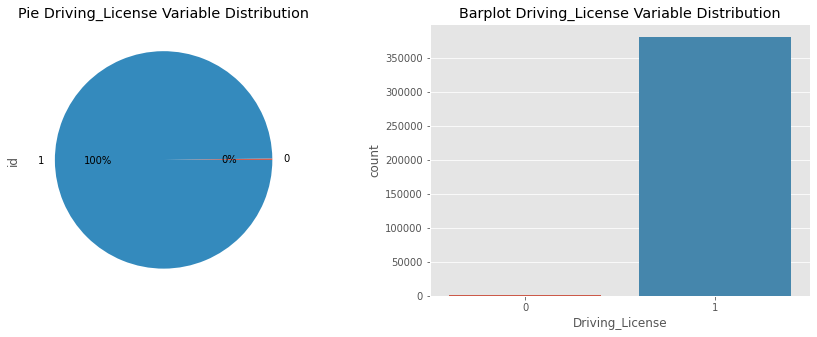

In [37]:
catcharts(df, col1='Driving_License', col2='id')

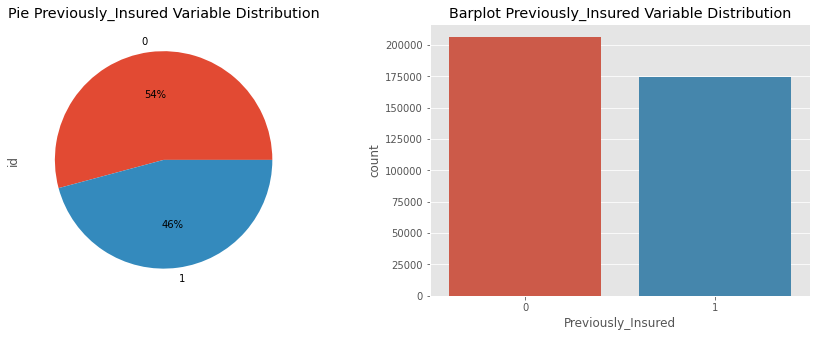

In [38]:
catcharts(df, col1='Previously_Insured', col2='id')

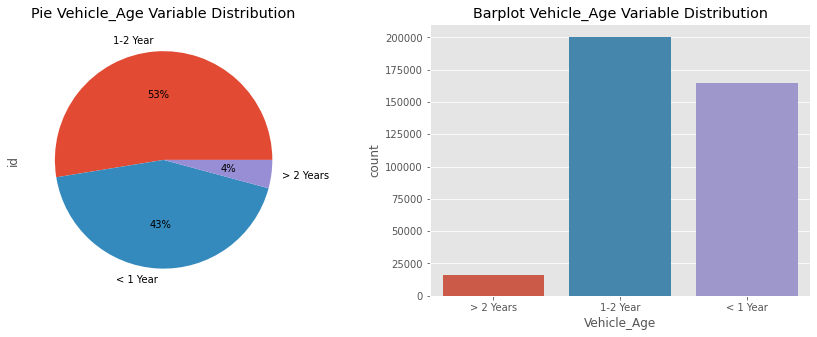

In [39]:
catcharts(df, col1='Vehicle_Age', col2='id')

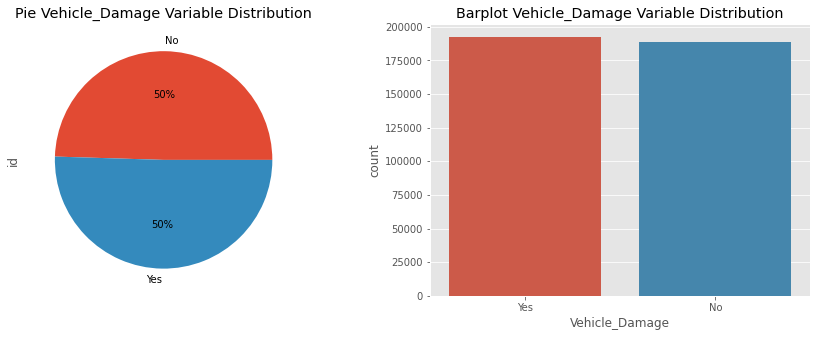

In [40]:
catcharts(df, col1='Vehicle_Damage', col2='id')

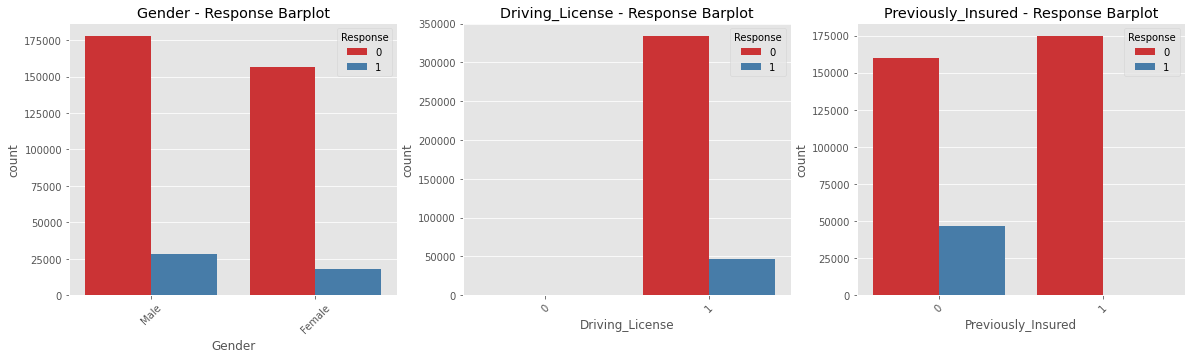

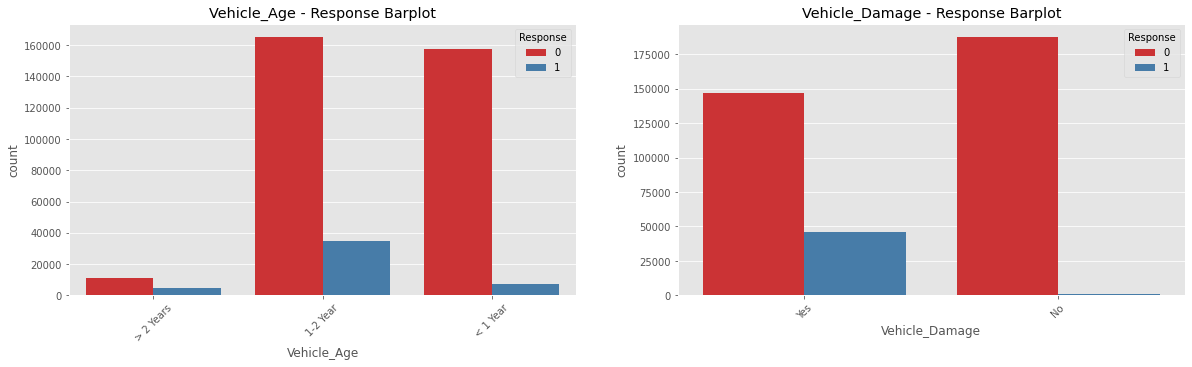

In [41]:
# new subset for a bivariate analysis
cat2 = pd.concat([y,cat], axis=1)
plt.rcParams['figure.figsize']=(20,5)

plt.subplot(1,3,1)
sns.countplot(x=cat2['Gender'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Gender'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,2)
sns.countplot(x=cat2['Driving_License'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Driving_License'))
plt.xticks(rotation=45)
        
plt.subplot(1,3,3)
sns.countplot(x=cat2['Previously_Insured'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Previously_Insured'))
plt.xticks(rotation=45)

plt.show()

plt.rcParams['figure.figsize']=(20,5)
plt.subplot(1,2,1)
sns.countplot(x=cat2['Vehicle_Age'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Vehicle_Age'))
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.countplot(x=cat2['Vehicle_Damage'], hue=y, data=cat2, palette="Set1")
plt.title('{} - Response Barplot'.format('Vehicle_Damage'))
plt.xticks(rotation=45)
    
plt.show()

### Statistical Analysis

In [42]:
# Univariate analysis looking at frequency
for col in cat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0    count  frequency
Gender                   
Female  175020   0.459239
Male    206089   0.540761

 col_0             count  frequency
Driving_License                   
0                   812   0.002131
1                380297   0.997869

 col_0                count  frequency
Previously_Insured                   
0                   206481    0.54179
1                   174628    0.45821

 col_0         count  frequency
Vehicle_Age                   
1-2 Year     200316   0.525613
< 1 Year     164786   0.432385
> 2 Years     16007   0.042001

 col_0            count  frequency
Vehicle_Damage                   
No              188696   0.495123
Yes             192413   0.504877


# Pre-Processing

In the Pre-Processing activity is applied the same pipeline for all models.
Outliers from numerical features have been capped to avoid biased results and have been applied target encoding on categorical features instead of the classical one-hot encoding to improve the performance of models. 
Then have been removed predictors with zero variance because they don't produce any information for the models and have been removed correlated predictors to mitigate multicollinearity and improving stability of models, though ensembles trees are less sensitive on correlated predictors. 
At the end has been applied feature scaling to normalize the range of different input variables to a similar scale and so to optimize the process for models sensitive to feature magnitude.

### Numerical Features Pre-Processing

In [43]:
num_o = num.copy()

In [44]:
# outliers correction
for col in num_o.columns:
    q75, q25 = np.percentile(num_o[col].dropna(), [75 ,25])
    iqr = q75 - q25 
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5) 
    num_o[col].mask(num_o[col]<min, min, inplace=True)
    num_o[col].mask(num_o[col]>max, max, inplace=True)

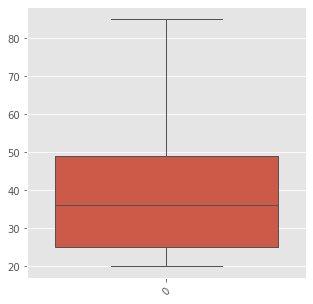

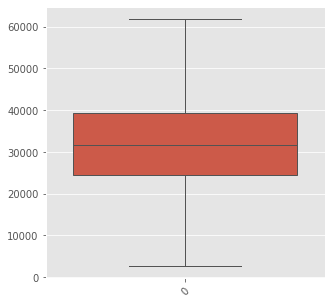

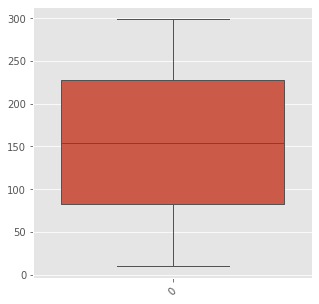

In [45]:
# check corrections
for col in num_o:
    plt.rcParams['figure.figsize']=(5,5)
    x=num_o[col]
    sns.boxplot(x,linewidth=1)
    plt.xticks(rotation=45)
    plt.show()

### Categorical Features Pre-Processing

In [46]:
# Transform in integer binary variables
y = y.astype('int')
cat2['Response'] = cat2['Response'].astype('int')
cat2['Driving_License'] = cat2['Driving_License'].astype('int')
cat2['Previously_Insured'] = cat2['Previously_Insured'].astype('int')

In [47]:
cat2['Gender']=cat2['Gender'].map({'Female':0,'Male':1})
cat2['Vehicle_Damage']=cat2['Vehicle_Damage'].map({'No':0,'Yes':1})

In [48]:
# calculate the mean target value per category for each feature and capture the result in a dictionary 
Vehicle_Age_LABELS = cat2.groupby(['Vehicle_Age'])['Response'].mean().to_dict()
# replace for each feature the labels with the mean target values
cat2['Vehicle_Age'] = cat2['Vehicle_Age'].map(Vehicle_Age_LABELS)


In [49]:
# Look at the new subset
target_cat = cat2.drop(['Response'], axis=1)
target_cat.shape

(381109, 5)

In [50]:
target_cat.head()

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage
0,1,1,0,0.293746,1
1,1,1,0,0.173755,0
2,1,1,0,0.293746,1
3,1,1,1,0.043705,0
4,0,1,1,0.043705,0


In [51]:
# Grasp all
X_all = pd.concat([num_o,target_cat], axis=1)

### Zero Variance Predictors

In [52]:
# Find features with variance equal zero 
to_drop = [col for col in X_all.columns if np.var(X_all[col]) == 0]
to_drop

[]

In [53]:
# Drop features 
X_all_v = X_all.drop(X_all[to_drop], axis=1)

### Correlated Predictors

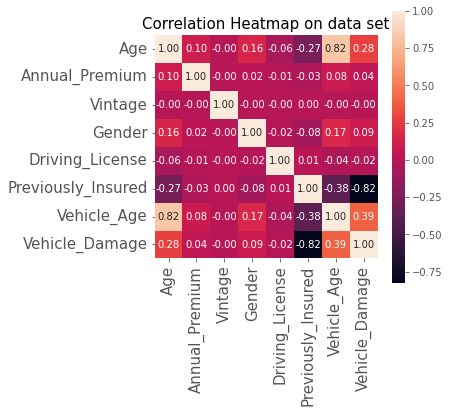

In [54]:
# Correlation 
corr_matrix = X_all_v.corr(method ='spearman')
sns.heatmap(corr_matrix, square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="15")
plt.xticks(fontsize="15")
plt.show()

In [55]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.80)]
to_drop

['Vehicle_Age', 'Vehicle_Damage']

In [56]:
# Drop features 
X_all_c = X_all_v.drop(X_all_v[to_drop], axis=1)

In [57]:
X_all_c.head()

,Age,Annual_Premium,Vintage,Gender,Driving_License,Previously_Insured
0,44,40454.0,217,1,1,0
1,76,33536.0,183,1,1,0
2,47,38294.0,27,1,1,0
3,21,28619.0,203,1,1,1
4,29,27496.0,39,0,1,1


In [58]:
# Normalization 
scaling = MinMaxScaler()
# Normalization of numerical features
num_sc = pd.DataFrame(scaling.fit_transform(X_all_c[['Age','Annual_Premium','Vintage']]), columns= ['Age','Annual_Premium','Vintage'])
# Grasp all
X_all_sc = pd.concat([num_sc, X_all_c[['Gender','Driving_License','Previously_Insured']]], axis=1)

In [59]:
# Split data set
# Break off train and test set from data
X_train, X_test, y_train, y_test = train_test_split(X_all_sc, y, train_size=0.8, test_size=0.2,
                                                    stratify=y,random_state=0)

In [60]:
X_train.to_csv('X_train.csv', index=False)

In [61]:
X_test.to_csv('X_test.csv', index=False)

In [62]:
y_train.to_csv('y_train.csv', index=False)

In [63]:
y_test.to_csv('y_test.csv', index=False)

# Spot check Models

Logistic Regression (LR) is used as a benchmark model, because it is usually used as reference in Insurance, 
and also because in terms of calibration for the evaluation it is a calibrated model.

For this job Logistic Regression (LR) has been compared with Gaussian Naive Bayes model (GNB), and Histogram-Based Gradient Boosting Machine (HGBM).

Each model is evaluated if it is properly calibrated, and eventually, is applied the Platt Scaling to perform a well-calibrated classifier. 

In [64]:
# check calibration
# Generate probability predictions from your model
def calibration(model, xdata, ydata, model_name):
    plt.rcParams['figure.figsize']=(15,5)
    probabilities = model.predict_proba(X_test)
    predicted_probabilities = probabilities[:, 1]

# Get true outcome value for each test observation
    test_outcomes = y_test

# Generate the calibration curve data
    calibration_curve_data = calibration_curve(test_outcomes, predicted_probabilities, n_bins=10)
    

# Plot the calibration curve
    plt.plot(calibration_curve_data[1], calibration_curve_data[0], marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed frequency')
    plt.title('{} Calibration Curve'.format(model_name))
    
    plt.show()
    

#### Logistic Regression Model

In [65]:
# LR model
start = time.time()
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)
LR = LogisticRegression(random_state=0)

param_grid = {}
LR_model = GridSearchCV(LR,param_grid,cv=skf)
LR_classifier = LR_model.fit(X_train, y_train)
# save the model to disk
with open('LR_classifier.pkl', 'wb') as pickle_out:
    serialized_classifier = pickle.dumps(LR_classifier)
    pickle_out.write(serialized_classifier)

# loading in the model to predict on the data
with open('LR_classifier.pkl', 'rb') as pickle_in:
    LR_classifier = pickle.load(pickle_in)
    
predictions_tr = LR_classifier.predict_proba(X_train)[:, 1]
predictions_t = LR_classifier.predict_proba(X_test)[:, 1]
LR_auc_train = roc_auc_score(y_train, predictions_tr)  
LR_auc_test = roc_auc_score(y_test, predictions_t) 
score= {'model':['LR'], 'auc_train':[LR_auc_train],'auc_test':[LR_auc_test]}
LR_score= pd.DataFrame(score)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 4.20258641242981s


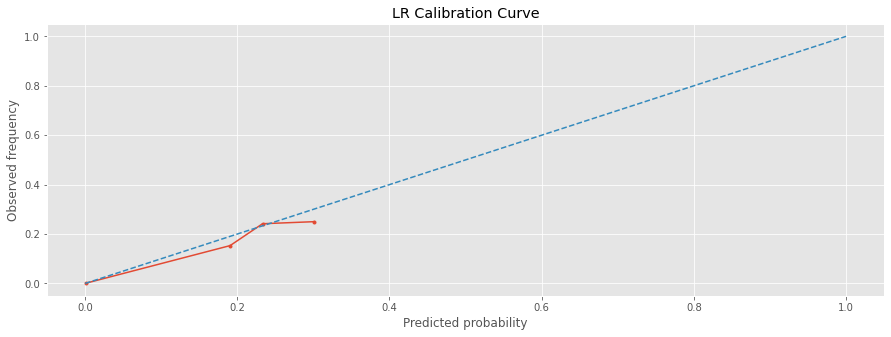

In [66]:
calibration(LR_classifier, X_test, y_test, "LR")

In [67]:
LR_score

,model,auc_train,auc_test
0,LR,0.779368,0.778922


#### Gaussian Naive Bayes Model

The Naive Bayes is not calibrated, so it is applied a Platt Scaling method to perform a well-calibrated model.
The method consists in fitting the predicted probabilities given by the uncalibrated model for the positive class to the sigmoid function.

In [68]:
# GNB model
start = time.time()
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)
GNB= GaussianNB()
param_grid = {}
GNB_model = GridSearchCV(GNB,param_grid,cv=skf)
GNB_classifier = GNB_model.fit(X_train, y_train)
# save the model to disk
with open('GNB_classifier.pkl', 'wb') as pickle_out:
    serialized_classifier = pickle.dumps(GNB_classifier)
    pickle_out.write(serialized_classifier)

# loading in the model to predict on the data
with open('GNB_classifier.pkl', 'rb') as pickle_in:
    GNB_classifier = pickle.load(pickle_in)
    
predictions_tr = GNB_classifier.predict_proba(X_train)[:, 1]
predictions_t = GNB_classifier.predict_proba(X_test)[:, 1]
GNB_auc_train = roc_auc_score(y_train, predictions_tr)  
GNB_auc_test = roc_auc_score(y_test, predictions_t) 
score= {'model':['GNB'], 'auc_train':[GNB_auc_train],'auc_test':[GNB_auc_test]}
GNB_score= pd.DataFrame(score)
stop = time.time()
print(f"Training time: {stop - start}s")


Training time: 0.9224696159362793s


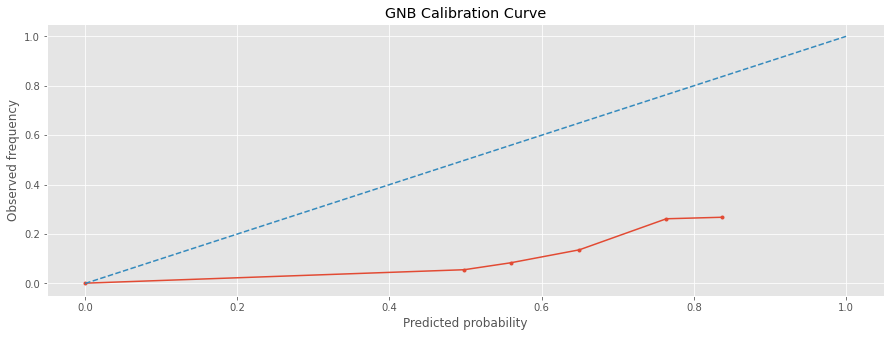

In [69]:
calibration(GNB_classifier, X_test, y_test, "GNB")

In [70]:
GNB_score

,model,auc_train,auc_test
0,GNB,0.805027,0.803807


In [71]:
# GNB model with calibration
start = time.time()
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)
GNB_C= CalibratedClassifierCV(base_estimator=GaussianNB(), method='sigmoid')
param_grid = {}
GNB_C_model = GridSearchCV(GNB_C,param_grid,cv=skf)
GNB_C_classifier = GNB_C.fit(X_train, y_train)
# save the model to disk
with open('GNB_classifier_.pkl', 'wb') as pickle_out:
    serialized_classifier = pickle.dumps(GNB_C_classifier)
    pickle_out.write(serialized_classifier)

# loading in the model to predict on the data
with open('GNB_classifier_.pkl', 'rb') as pickle_in:
    GNB_C_classifier = pickle.load(pickle_in)
    
predictions_tr = GNB_C_classifier.predict_proba(X_train)[:, 1]
predictions_t = GNB_C_classifier.predict_proba(X_test)[:, 1]
GNB_auc_train = roc_auc_score(y_train, predictions_tr)  
GNB_auc_test = roc_auc_score(y_test, predictions_t) 
score= {'model':['GNB'], 'auc_train':[GNB_auc_train],'auc_test':[GNB_auc_test]}
GNB_score= pd.DataFrame(score)
stop = time.time()
print(f"Training time: {stop - start}s")


Training time: 1.4051926136016846s


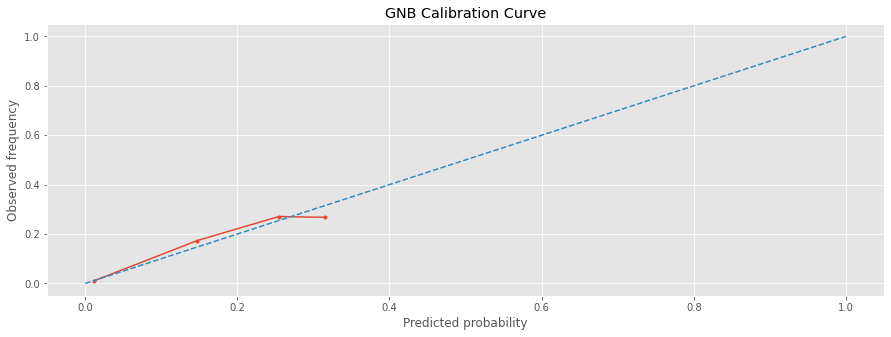

In [72]:
calibration(GNB_C_classifier, X_test, y_test, "GNB")

In [73]:
GNB_score

,model,auc_train,auc_test
0,GNB,0.805083,0.803694


#### Histogram-Based Gradient Boosting Machine Model

In [74]:
# HGBM model
start = time.time()
skf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)
HGBM= HistGradientBoostingClassifier(random_state=0)
param_grid = {}
HGBM_model = GridSearchCV(HGBM,param_grid,cv=skf)
HGBM_classifier = HGBM_model.fit(X_train, y_train)
# save the model to disk
with open('HGBM_classifier.pkl', 'wb') as pickle_out:
    serialized_classifier = pickle.dumps(HGBM_classifier)
    pickle_out.write(serialized_classifier)

# loading in the model to predict on the data
with open('HGBM_classifier.pkl', 'rb') as pickle_in:
    HGBM_classifier = pickle.load(pickle_in)
    
predictions_tr = HGBM_classifier.predict_proba(X_train)[:, 1]
predictions_t = HGBM_classifier.predict_proba(X_test)[:, 1]
HGBM_auc_train = roc_auc_score(y_train, predictions_tr)  
HGBM_auc_test = roc_auc_score(y_test, predictions_t) 
score= {'model':['HGBM'], 'auc_train':[HGBM_auc_train],'auc_test':[HGBM_auc_test]}
HGBM_score= pd.DataFrame(score)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 14.550823211669922s


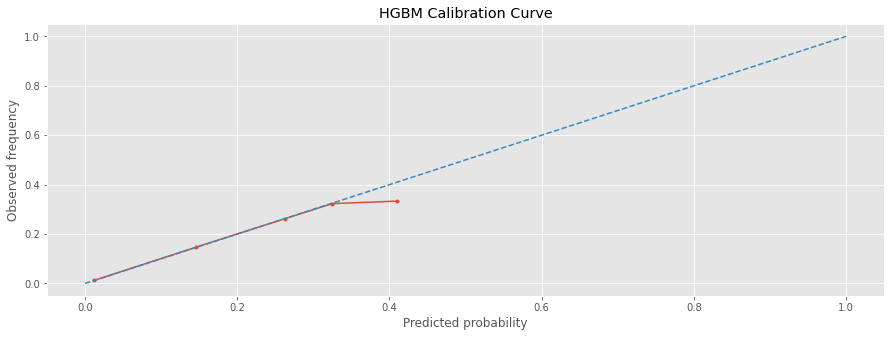

In [75]:
calibration(HGBM_classifier, X_test, y_test, "HGBM")

In [76]:
HGBM_score

,model,auc_train,auc_test
0,HGBM,0.832758,0.82607


In [77]:
score_cal = LR_score.append(GNB_score)
score_cal = score_cal.append(HGBM_score)
score_cal

,model,auc_train,auc_test
0,LR,0.779368,0.778922
0,GNB,0.805083,0.803694
0,HGBM,0.832758,0.826070


Spot Check Models


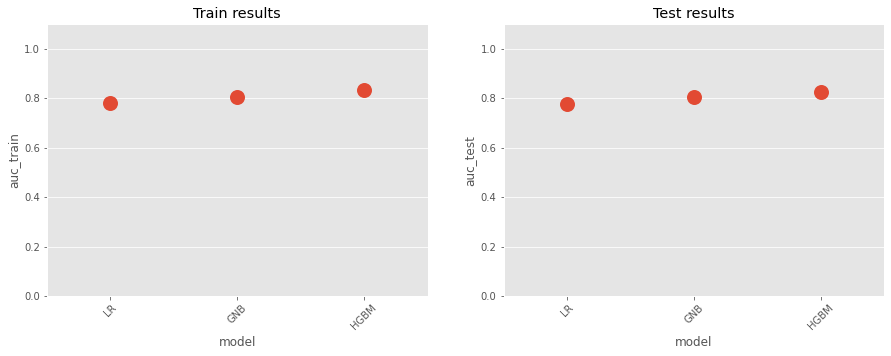

In [78]:
# Plot results for a graphical comparison
print("Spot Check Models")
plt.rcParams['figure.figsize']=(15,5)
plt.figure()
plt.subplot(1,2,1)  
sns.stripplot(x="model", y="auc_train",data=score_cal,size=15)
plt.xticks(rotation=45)
plt.title('Train results')
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.subplot(1,2,2)
sns.stripplot(x="model", y="auc_test",data=score_cal,size=15)
plt.xticks(rotation=45)
plt.title('Test results')
axes = plt.gca()
axes.set_ylim([0,1.1])
plt.show()

Hist Gradient Boosting Machine shows the best performance, then it's been fine tuned both in the hyperparameters and threshold optimization.

# Tuning

In [79]:
start = time.time()
# cross validation
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
# define models and hyperparameters
HGBM = HistGradientBoostingClassifier(random_state=0)
# define grid search
hyp_space = {"max_depth": [10,21],
             "learning_rate": [0.02,0.5],
             "max_bins": [80, 195]}
# Tuning and fit the model 
HGBM_model_ = GridSearchCV(HGBM, hyp_space, n_jobs=-1, cv=skf, scoring='roc_auc', error_score=0).fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop-start}s")

Training time: 40.6683464050293s


In [80]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score'] 
    std_score = results.cv_results_['std_test_score'] 
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display(HGBM_model_)

Best parameters are: {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 10}


0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 10}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 80, 'max_depth': 21}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 195, 'max_depth': 10}
0.827 + or -0.001 for the {'learning_rate': 0.02, 'max_bins': 195, 'max_depth': 21}
0.821 + or -0.006 for the {'learning_rate': 0.5, 'max_bins': 80, 'max_depth': 10}
0.825 + or -0.002 for the {'learning_rate': 0.5, 'max_bins': 80, 'max_depth': 21}
0.825 + or -0.001 for the {'learning_rate': 0.5, 'max_bins': 195, 'max_depth': 10}
0.825 + or -0.001 for the {'learning_rate': 0.5, 'max_bins': 195, 'max_depth': 21}


# Modelling

In [81]:
# HGBM Model
HGBM_ = HistGradientBoostingClassifier(random_state=0,learning_rate=0.02, max_bins=80, max_depth= 10)
                               
# fit the model
HGBM_tclassifier = HGBM_.fit(X_train, y_train)

In [82]:
# save the model to disk
with open('HGBM_tclassifier.pkl', 'wb') as pickle_out:
    serialized_classifier = pickle.dumps(HGBM_tclassifier)
    pickle_out.write(serialized_classifier)

# loading in the model to predict on the data
with open('HGBM_tclassifier.pkl', 'rb') as pickle_in:
    HGBM_tclassifier = pickle.load(pickle_in)

In [83]:
start = time.time()
# prediction
predictions_tr = HGBM_classifier.predict_proba(X_train)[:, 1]
predictions_tr_ = pd.DataFrame(predictions_tr, columns=['y_train_pred'])
predictions_te = HGBM_tclassifier.predict_proba(X_test)[:, 1]
predictions_te_ = pd.DataFrame(predictions_te, columns=['y_test_pred'])
stop = time.time()
print(f"Training time: {stop-start}s")

Training time: 0.5147049427032471s


# Evaluation

In [84]:
auc_train = roc_auc_score(y_train, HGBM_tclassifier.predict_proba(X_train)[:, 1])  
auc_test = roc_auc_score(y_test, HGBM_tclassifier.predict_proba(X_test)[:, 1]) 

In [85]:
# metrics table
d1 = {'evaluation': ['AUC'],
     'model': ['HGBM'],
    'train': [auc_train],
    'test': [auc_test]
        }
df1 = pd.DataFrame(data=d1, columns=['model','evaluation','train','test'])
print('HGBM evaluation on cross-sell prediction')
df1

HGBM evaluation on cross-sell prediction


,model,evaluation,train,test
0,HGBM,AUC,0.829531,0.826265


### Threshold optimization

In [86]:
# Use f1_score to maximize
metric = f1_score

# Generate a range of classification thresholds to evaluate
thresholds = np.arange(0.0, 1.01, 0.01)

# Compute the metric for each threshold
metric_values = [metric(y_test, np.where(predictions_te >= threshold, 1, 0)) for threshold in thresholds]

# Find the best threshold that maximizes the metric
best_threshold = thresholds[np.argmax(metric_values)]

print("Best threshold:", best_threshold)


Best threshold: 0.21


ROC on test


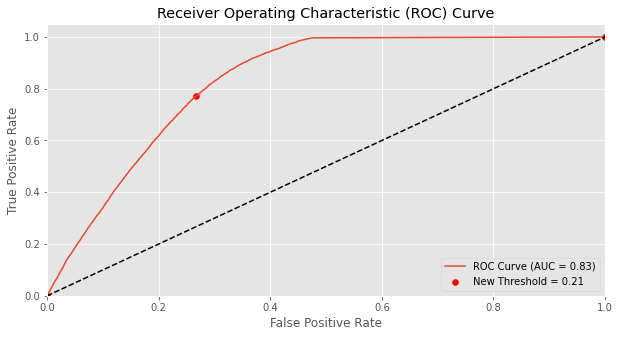

In [87]:
# compute the tpr and fpr from the prediction
fpr, tpr, thresholds = roc_curve(y_test, predictions_te)

# Plot the ROC curve
plt.rcParams['figure.figsize']=(10,5)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Adjust the threshold and compute the true positive rate (TPR) and false positive rate (FPR)
threshold = 0.21
y_pred = np.where(predictions_te >= threshold, 1, 0)
fpr_new, tpr_new, _ = roc_curve(y_test, y_pred)

# Plot the new point on the ROC curve
plt.scatter(fpr_new, tpr_new, c='r', label='New Threshold = %0.2f' % threshold)
plt.legend(loc="lower right")
print('ROC on test')
plt.show()


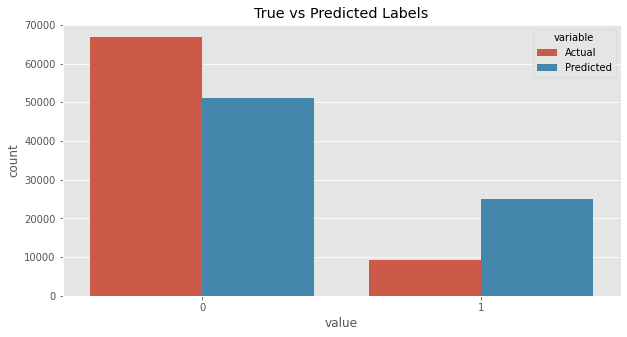

In [88]:
# create a barplot for a comparison between test values and predicted values
y_test_= np.array(y_test)
y_test_ = y_test_.flatten()
y_pred = y_pred.flatten()
df_2 = pd.DataFrame({'Actual': y_test_, 'Predicted': y_pred})
sns.countplot(x='value', hue='variable', data=pd.melt(df_2))
plt.title('True vs Predicted Labels')
plt.show()

# Feature Importance

The most relevant feature with impact on the target variable is "Previously_Insured".

In [89]:
HGBM_explainer = shap.TreeExplainer(HistGradientBoostingClassifier(random_state=0,learning_rate=0.02, max_bins=80, max_depth= 10).fit(X_train, y_train))

In [90]:
# save the model to disk
with open('HGBM_explainer.pkl', 'wb') as pickle_out:
    serialized_explainer = pickle.dumps(HGBM_explainer)
    pickle_out.write(serialized_explainer)

# loading in the model to predict on the data
with open('HGBM_explainer.pkl', 'rb') as pickle_in:
    HGBM_explainer = pickle.load(pickle_in)


In [91]:
shap_values = HGBM_explainer.shap_values(X_test)

In [92]:
# Save the SHAP values on the disk
np.save('shap_values.npy', shap_values)

# load shap_values:
shap_values = np.load('shap_values.npy')

HGBM SHAP BARPLOT on test Values


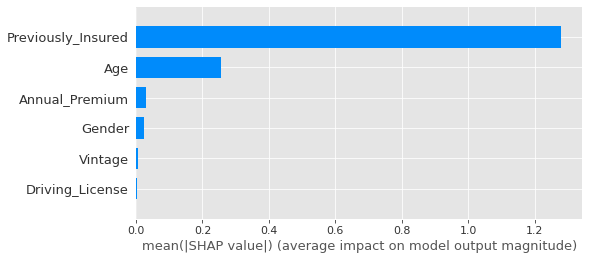

In [93]:
# Global SHAP on test
print("HGBM SHAP BARPLOT on test Values")
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns,plot_type='bar')

# Profiling Interested Customers

The second step followed is about the segmentation of the interested customers. 
For this purpose has been applied the K-Means clustering to the portion of data set with "Response" variable equal to "1" class.
Then is performed a distribution analysis of the first cluster between numerical features as "Annual Premium" and "Age" vs 
categorical features.

In [94]:
df_2 = df.copy()

In [95]:
df_2 = df_2[df_2['Response']==1]

### Clustering Numerical Features

In [96]:
# Select numerical columns
num_1 = df_2[numerical_cols]

In [97]:
num_1.head()

,Age,Annual_Premium,Vintage
0,44,40454.0,217
2,47,38294.0,27
7,56,32031.0,72
10,47,47576.0,46
15,37,2630.0,147


In [98]:
# Standardization of data
sc = StandardScaler()
num_sc = sc.fit_transform(num_1)

In [99]:
np.random.seed(0)
for n_cluster in range(2,10):
    clustering = KMeans(n_clusters=n_cluster, random_state=0).fit(num_sc)
    preds = clustering.predict(num_sc)
    silhouette_avg = silhouette_score(num_sc, preds)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))


Silhouette Score for 2 Clusters: 0.2636
Silhouette Score for 3 Clusters: 0.2538
Silhouette Score for 4 Clusters: 0.2826
Silhouette Score for 5 Clusters: 0.2472
Silhouette Score for 6 Clusters: 0.2638
Silhouette Score for 7 Clusters: 0.2766
Silhouette Score for 8 Clusters: 0.2739
Silhouette Score for 9 Clusters: 0.2746


In [100]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(num_sc)

In [101]:
# save the model to disk
with open('kmeans.pkl', 'wb') as pickle_out:
    serialized_kmeans = pickle.dumps(kmeans)
    pickle_out.write(serialized_kmeans)

# loading in the model to predict on the data
with open('kmeans.pkl', 'rb') as pickle_in:
    kmeans = pickle.load(pickle_in)


In [102]:
labels = kmeans.predict(num_sc)

In [103]:
cluster_num = num_1.copy()
cluster_num['kmeans_cluster'] = labels
len(np.unique(kmeans.labels_))

4

In [104]:
cluster_num['kmeans_cluster'].value_counts()

2    14395
3    14170
1     9570
0     8575
Name: kmeans_cluster, dtype: int64

In [105]:
df_cluster = pd.concat([df_2, cluster_num['kmeans_cluster']], axis=1)

In [106]:
# Group clusters by Annual Premium
df = df_cluster.groupby(df_cluster['kmeans_cluster'], as_index=False)['Annual_Premium'].sum()
df['PERCENTAGE'] = df['Annual_Premium']/df['Annual_Premium'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Annual_Premium', ascending = False).reset_index(drop=True)
df_AP = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Annual_Premium':"{:,.2f}"})
df_AP


,kmeans_cluster,Annual_Premium,PERCENTAGE
0,2,"520,325,095.00",35.25
1,3,"518,999,956.00",35.16
2,1,"409,911,674.00",27.77
3,0,"26,990,447.00",1.83


In [107]:
# Group clusters by Age
df = df_cluster.groupby(df_cluster['kmeans_cluster'], as_index=False)['Age'].mean()
df['PERCENTAGE'] = df['Age']/df['Age'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Age', ascending = False).reset_index(drop=True)
df_AGE = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Age':"{:,.2f}"})
df_AGE

,kmeans_cluster,Age,PERCENTAGE
0,1,59.30,33.24
1,0,41.92,23.50
2,3,38.87,21.79
3,2,38.29,21.47


In [108]:
# Select top cluster per Annual Premium and Age
df_cluster_AP = df_cluster[df_cluster['kmeans_cluster']==2].reset_index(drop=True)
df_cluster_AGE = df_cluster[df_cluster['kmeans_cluster']==1].reset_index(drop=True)


#### Distribution analysis of the top cluster

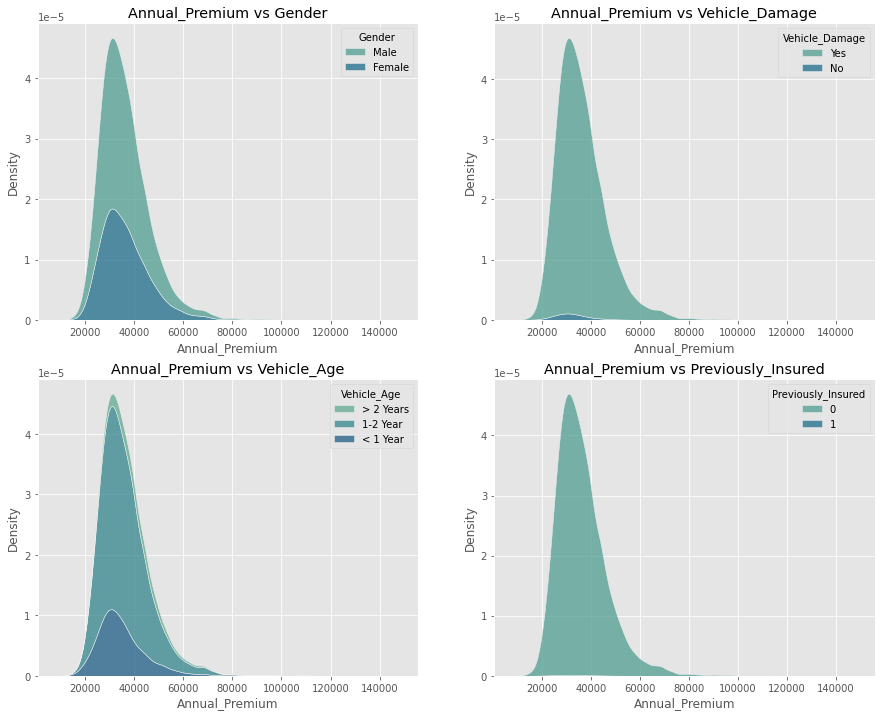

In [109]:
# Plot Annual Premium vs Gender, Vehicle_Damage, Vehicle_Age, Previously_Insured
plt.rcParams['figure.figsize']=(15,12)
plt.subplot(2,2,1)
sns.kdeplot(x=df_cluster_AP['Annual_Premium'],hue=df_cluster_AP['Gender'],palette="crest", multiple='stack')
plt.title('Annual_Premium vs Gender')
plt.subplot(2,2,2)
sns.kdeplot(x=df_cluster_AP['Annual_Premium'],hue=df_cluster_AP['Vehicle_Damage'],palette="crest", multiple='stack')
plt.title('Annual_Premium vs Vehicle_Damage')
plt.subplot(2,2,3)
sns.kdeplot(x=df_cluster_AP['Annual_Premium'],hue=df_cluster_AP['Vehicle_Age'],palette="crest", multiple='stack')
plt.title('Annual_Premium vs Vehicle_Age')
plt.subplot(2,2,4)
sns.kdeplot(x=df_cluster_AP['Annual_Premium'],hue=df_cluster_AP['Previously_Insured'],palette="crest", multiple='stack')
plt.title('Annual_Premium vs Previously_Insured')

plt.show()

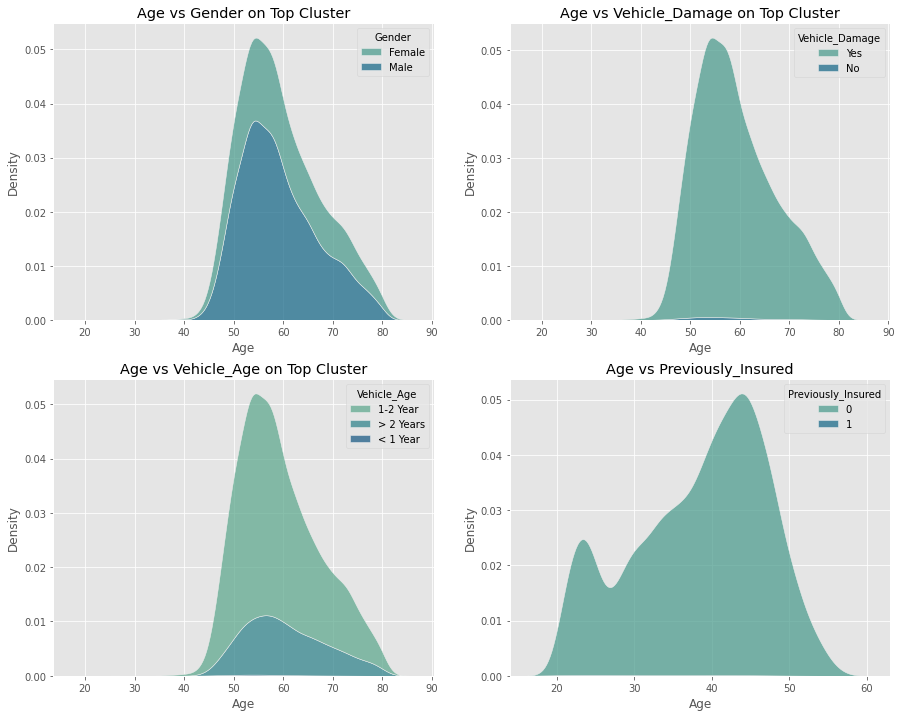

In [110]:
# Plot Age vs Gender, Vehicle_Damage, Vehicle_Age, Previously_Insured
plt.rcParams['figure.figsize']=(15,12)
plt.subplot(2,2,1)
sns.kdeplot(x=df_cluster_AGE['Age'],hue=df_cluster_AGE['Gender'],palette="crest", multiple='stack')
plt.title('Age vs Gender on Top Cluster')
plt.subplot(2,2,2)
sns.kdeplot(x=df_cluster_AGE['Age'],hue=df_cluster_AGE['Vehicle_Damage'],palette="crest", multiple='stack')
plt.title('Age vs Vehicle_Damage on Top Cluster')
plt.subplot(2,2,3)
sns.kdeplot(x=df_cluster_AGE['Age'],hue=df_cluster_AGE['Vehicle_Age'],palette="crest", multiple='stack')
plt.title('Age vs Vehicle_Age on Top Cluster')
plt.subplot(2,2,4)
sns.kdeplot(x=df_cluster_AP['Age'],hue=df_cluster_AP['Previously_Insured'],palette="crest", multiple='stack')
plt.title('Age vs Previously_Insured')


plt.show()